In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle

plt.style.use('ggplot')

In [2]:
cd ..

/Users/odatakuma/cmu/FleetAI


## Preprocessing

In [3]:
df = pd.read_csv('data/nyc_taxi/trips_2016-05.csv',
                 usecols=[
                     'plat', 'plon',
                     'hour',
                     'minute',
                     'dayofweek',
                     'date'
                 ], dtype={
                     'hour':np.float32,
                     'minute':np.int16,
                     'dayofweek':np.int16,
                     'date':np.int16
                 }
                )
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12806249 entries, 0 to 12806248
Data columns (total 6 columns):
date         int16
dayofweek    int16
hour         float32
minute       int16
plat         float64
plon         float64
dtypes: float32(1), float64(2), int16(3)
memory usage: 415.2 MB


In [4]:
df['hour'] += 0.5 * (df.minute / 30).astype(int)
df.hour.unique()

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5])

In [9]:
lat0 = 40.6
lon0 = -74.041
dl = 0.3 / (219 - 1)
df['x'] = ((df['plon'] - lon0) / dl).astype(np.uint8)
df['y'] = ((df['plat'] - lat0) / dl).astype(np.uint8)
print df.x.max(), df.x.min(), len(df.x.unique())
print df.y.max(), df.y.min(), len(df.y.unique())

211 0 212
218 0 219


In [10]:
Nx = 212
Ny = 219

df = df.drop(['plat', 'plon'], axis=1)
demand = df.groupby(['date', 'dayofweek', 'hour', 'x', 'y'])[['minute']].count().rename(columns={'minute':'count'})
demand = demand.reset_index()
demand['date_dayofweek_hour'] = zip(demand.date, demand.dayofweek, demand.hour)
demand['x_y'] = zip(demand.x, demand.y)
demand.head()

,date,dayofweek,hour,x,y,count,date_dayofweek_hour,x_y
0,1,6,0,9,13,1,"(1, 6, 0.0)","(9, 13)"
1,1,6,0,15,29,1,"(1, 6, 0.0)","(15, 29)"
2,1,6,0,16,77,1,"(1, 6, 0.0)","(16, 77)"
3,1,6,0,17,30,1,"(1, 6, 0.0)","(17, 30)"
4,1,6,0,17,76,4,"(1, 6, 0.0)","(17, 76)"


In [11]:
df = demand.pivot(index='date_dayofweek_hour', columns='x_y', values='count')
df = df.fillna(0)
df.head()

x_y,"(0, 14)","(0, 15)","(1, 12)","(1, 15)","(1, 18)","(1, 21)","(2, 10)","(2, 11)","(2, 13)","(2, 14)",...,"(210, 65)","(210, 74)","(210, 77)","(210, 80)","(210, 98)","(210, 104)","(211, 69)","(211, 78)","(211, 83)","(211, 92)"
date_dayofweek_hour,,,,,,,,,,,,,,,,,,,,,
"(1, 6, 0.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 6, 0.5)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 6, 1.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 6, 1.5)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 6, 2.0)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
W = np.zeros((len(df), Nx, Ny))
for x, y in df.columns:
    W[:, x, y] = df[(x, y)].astype(np.int16)

In [13]:
N = int(len(df ) * 0.7)
W_train = W[:N]
W_test = W[N:]

In [14]:
df['date'] = 0
df['dayofweek'] = 0
df['hour'] = 0
df[['date', 'dayofweek', 'hour']] = list(df.index.values)
df = df.reset_index(drop=True)
df['sin_day'] = np.sin(df.dayofweek % 7)
df['cos_day'] = np.cos(df.dayofweek % 7)
df['sin_hour'] = np.sin(df.hour % 7)
df['cos_hour'] = np.cos(df.hour % 7)
df = df[['sin_day', 'cos_day', 'sin_hour', 'cos_hour']]
df.head()

x_y,sin_day,cos_day,sin_hour,cos_hour
0,-0.279415,0.96017,0.000000,1.000000
1,-0.279415,0.96017,0.479426,0.877583
2,-0.279415,0.96017,0.841471,0.540302
3,-0.279415,0.96017,0.997495,0.070737
4,-0.279415,0.96017,0.909297,-0.416147


In [15]:
zones = pd.read_csv("data/table/zones.csv",
                    usecols=['geohash', 'lat', 'lon', 'road_density', 'intxn_density'])
zones.head()

,geohash,lat,lon,road_density,intxn_density
0,dr5qgxx,40.603358,-74.015682,32,35
1,dr5qgxy,40.604832,-74.017029,34,8
2,dr5qgxz,40.604637,-74.015335,0,0
3,dr5qgz5,40.600984,-74.009745,13,5
4,dr5qgz7,40.602178,-74.010322,28,9


In [16]:
lat0 = 40.6
lon0 = -74.04
dl = 0.3 / (219 - 1)
zones['x'] = ((zones['lon'] - lon0) / dl).astype(np.uint8)
zones['y'] = ((zones['lat'] - lat0) / dl).astype(np.uint8)
print zones.x.max(), zones.x.min(), len(zones.x.unique())
print zones.y.max(), zones.y.min(), len(zones.y.unique())

210 0 211
218 0 219


In [17]:
valid_x = zones.x.values
valid_y = zones.y.values
def MSE(predictions, targets):
    mse = 0
    for pred, target in zip(predictions, targets): 
        mse += ((pred[valid_x, valid_y] - target[valid_x, valid_y])**2).mean()
    return mse / len(predictions)

# Benchmark

In [18]:
print MSE(W_train[1:-1], W_train[2:])
print MSE(W_test[1:-1], W_test[2:])

1.35947416943
1.20966644011


In [21]:
from keras.models import Sequential
from keras.layers import Convolution2D

def simple_network():
    model = Sequential()
    model.add(Convolution2D(1, 1, 1, input_shape=(2, Nx, Ny)))
    model.compile(loss='mean_squared_error',  optimizer='adam')
    return model

In [22]:
def generate_samples(data, batch_size, create_features):
    N = len(data)
    while 1:
        rands= np.random.randint(2, N, batch_size)
        x_batch, y_batch = create_features(data, rands)
        yield (x_batch, y_batch)
        
def simple_features(W, p):
    Y = np.array([W[i:i+1] for i in p])
    X = np.array([[W[i-2], W[i-1]] for i in p])
    return X, Y

In [23]:
model = simple_network()
model.fit_generator(generate_samples(W_train, 32, simple_features), 32*40, 10)

Epoch 1/10
1280/1280 [==============================] - 9s - loss: 1.0313      

In [24]:
X, Y = simple_features(W_train, range(2, len(W_train)))
X_, Y_ = simple_features(W_test, range(2, len(W_test)))

print MSE(model.predict(X)[:, 0], Y[:,0])
print MSE(model.predict(X_)[:, 0], Y_[:,0])

1.34423218249
1.19938473861


## Use only previous frames as input features

In [54]:
def build_network(input_length, f1=4, f2=8):
    model = Sequential()
    model.add(Convolution2D(f1, 5, 5, input_shape=(input_length, Nx, Ny), activation='relu', border_mode='same'))
    model.add(Convolution2D(f2, 3, 3, activation='relu', border_mode='same'))
    model.add(Convolution2D(1, 1, 1, activation='relu', border_mode='same'))
    model.compile(loss='mean_squared_error',  optimizer='adam')
    return model

In [27]:
model = build_network(2)
model.fit_generator(generate_samples(W_train, 32, simple_features), 32*40, 10)

Epoch 1/10
1280/1280 [==============================] - 127s - loss: 1.7025     

In [28]:
X, Y = simple_features(W_train, range(2, len(W_train)))
X_, Y_ = simple_features(W_test, range(2, len(W_test)))

print MSE(model.predict(X)[:, 0], Y[:,0])
print MSE(model.predict(X_)[:, 0], Y_[:,0])

1.13602100693
0.987196346458


## Add datetime info to the input

In [21]:
def generate_samples(main, aux, batch_size, create_features):
    N = len(main)
    while 1:
        rands= np.random.randint(2, N, batch_size)
        x_batch, y_batch = create_features(main, aux, rands)
        yield (x_batch, y_batch)

def complex_features(W, aux, p):
    Y = np.array([W[i:i+1] for i in p])
    X = np.array([[W[i-2], W[i-1]] + [np.ones((Nx, Ny)) * x for x in aux[i]] for i in p])
    return X, Y

In [38]:
model = build_network(6, f1=4, f2=8)
model.fit_generator(generate_samples(W_train, df.values[:len(W_train)], 32, complex_features), 32*40, 10)

Epoch 1/10
1280/1280 [==============================] - 147s - loss: 1.7718     

Exception: Error when checking : expected convolution2d_input_7 to have shape (None, 6, 211, 219) but got array with shape (1039, 2, 211, 219)

In [40]:
X, Y = complex_features(W_train, df.values[:len(W_train)], range(2, len(W_train)))
X_, Y_ = complex_features(W_test, df.values[:len(W_test)], range(2, len(W_test)))

print MSE(model.predict(X)[:, 0], Y[:,0])
print MSE(model.predict(X_)[:, 0], Y_[:,0])

1.12791479021
0.983772959562


In [44]:
model = build_network(6, f1=16, f2=32)
model.fit_generator(generate_samples(W_train, df.values[:len(W_train)], 32, complex_features), 32*40, 10)

Epoch 1/10
1280/1280 [==============================] - 421s - loss: 1.2124     

In [45]:
X, Y = complex_features(W_train, df.values[:len(W_train)], range(2, len(W_train)))
X_, Y_ = complex_features(W_test, df.values[:len(W_test)], range(2, len(W_test)))

print MSE(model.predict(X)[:, 0], Y[:,0])
print MSE(model.predict(X_)[:, 0], Y_[:,0])

1.09674110027
0.959529617516


In [41]:
np.sqrt(1.09674110027)

1.0472540762728022

In [42]:
np.sqrt(0.959529617516)

0.97955582664593444

In [56]:
model_json = model.to_json()
with open("data/model/demand/model.json", "w") as f:
    f.write(model_json)
# serialize weights to HDF5
model.save_weights("data/model/demand/model.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
from keras.models import model_from_json

# load json and create model
with open('data/model/demand/model.json', 'r') as f:
    model = f.read()
model = model_from_json(model)
# load weights into new model
model.load_weights("data/model/demand/model.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [38]:
def plot_state(W_target, W_pred):
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title('Target')
    plt.xticks([])
    plt.yticks([])
    plt.pcolor(np.arange(Nx), np.arange(Ny), np.log(1+W_target.T))
    plt.axis([0, Nx-1, 0, Ny-1])
    plt.subplot(122)
    plt.title('Prediction')
    plt.xticks([])
    plt.yticks([])
    plt.pcolor(np.arange(Nx), np.arange(Ny), np.log(1+W_pred.T))
    plt.axis([0, Nx-1, 0, Ny-1])
    return plt

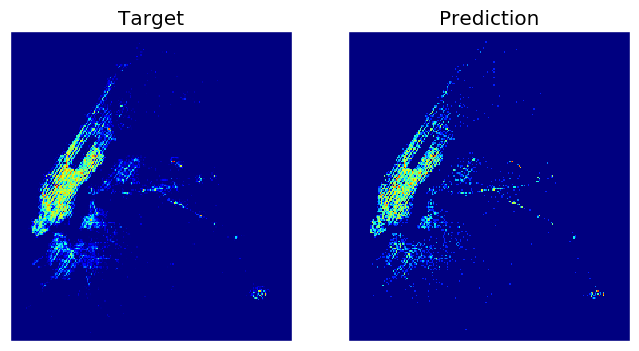

In [39]:
n = 1000
X, Y = complex_features(W, df.values, [n])
W_pred = model.predict(X)[0,0]
W_target = W[n]
plot_state(W_pred, W_target);

In [40]:
W.shape

(1488, 212, 219)